<a href="https://colab.research.google.com/github/solovee/Detector-de-Spam/blob/main/spamDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'spam-mails-dataset' dataset.
Path to dataset files: /kaggle/input/spam-mails-dataset


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
df = pd.read_csv(f'{path}/spam_ham_dataset.csv')

In [4]:
df['label'].value_counts()

,count
label,
ham,3672
spam,1499


In [7]:
def limpar_texto(texto):
    # 1. Remove "Subject:" (independente de maiúscula/minúscula)
    texto = re.sub(r"(?i)subject:\s*", "", texto)

    # 2. Remove quebras de linha e tabs
    texto = re.sub(r"[\r\n\t]+", " ", texto)

    # 3. Remove chaves e outros símbolos opcionais (se quiser mais limpo)
    texto = re.sub(r"[{}]+", "", texto)

    # 4. Troca múltiplos espaços por um só
    texto = re.sub(r"\s+", " ", texto).strip()

    return texto

# Aplicar no DataFrame
df["text_clean"] = df["text"].apply(limpar_texto)

In [8]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [9]:
df

,Unnamed: 0,label,text,label_num,text_clean
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol ; meter # : 988291 this is a fo...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"hpl nom for january 9 , 2001 ( see attached fi..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"neon retreat ho ho ho , we ' re around to that..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"photoshop , windows , office . cheap . main tr..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,re : indian springs this deal is to book the t...
...,...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0,put the 10 on the ft the transport volumes dec...
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,3 / 4 / 2000 and following noms hpl can ' t ta...
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0,"calpine daily gas nomination > > julie , as i ..."
5169,1409,ham,Subject: industrial worksheets for august 2000...,0,industrial worksheets for august 2000 activity...


In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text_clean"].tolist(), df["label_num"].tolist(), test_size=0.2, random_state=42
)

# Tokenizer BERT base uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizar
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

# Criar Dataset customizado
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset   = TextDataset(val_encodings, val_labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
from transformers import BertForSequenceClassification

# Carregar BERT pré-treinado com cabeça de classificação
num_labels = len(set(df["label_num"]))  # número de classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)  # multi-classe
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),        # use 'binary' se for binário
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }


In [14]:
!pip install --upgrade transformers


In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,

    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [17]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: leo-solovijovas (leo-solovijovas-instituto-federal-de-educa-o) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.657900
20,0.474700
30,0.501800
40,0.309000
50,0.265900
60,0.140100
70,0.185200
80,0.091700
90,0.311900
100,0.174700


TrainOutput(global_step=1551, training_loss=0.062278502173071786, metrics={'train_runtime': 329.6238, 'train_samples_per_second': 37.643, 'train_steps_per_second': 4.705, 'total_flos': 408085246863360.0, 'train_loss': 0.062278502173071786, 'epoch': 3.0})

In [18]:
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.06573383510112762, 'eval_accuracy': 0.9884057971014493, 'eval_f1': 0.9884057971014493, 'eval_precision': 0.9884057971014493, 'eval_recall': 0.9884057971014493, 'eval_runtime': 3.7309, 'eval_samples_per_second': 277.416, 'eval_steps_per_second': 34.845, 'epoch': 3.0}


In [22]:
import torch

# Exemplo de string nova
novo_texto = "you won the lottery"

# Tokenizar
inputs = tokenizer(
    novo_texto,
    truncation=True,
    padding=True,
    max_length=64,  # mesmo valor usado no treino
    return_tensors="pt"  # retorna tensores PyTorch
)


In [20]:
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}


In [25]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits


In [26]:
logits

tensor([[-3.1256,  4.2292]], device='cuda:0')

In [27]:
pred = torch.argmax(logits, dim=-1).item()
print("Classe prevista:", pred)


Classe prevista: 1


In [ ]:
# Pasta onde será salvo
save_path = "./bert_finetuned_model"

# Salvar modelo
model.save_pretrained(save_path)

# Salvar tokenizer
tokenizer.save_pretrained(save_path)


In [ ]:
import shutil

# Caminho da pasta que você quer zipar
path = "./bert_finetuned_model"

# Nome do arquivo zip que será criado (sem a extensão)
zip_name = "./bert_finetuned_model_zip"

# Criar o zip
shutil.make_archive(zip_name, 'zip', path)

print(f"Pasta {path} zipada como {zip_name}.zip")


In [28]:
import numpy as np

# predictions retorna um objeto com logits e labels
predictions = trainer.predict(val_dataset)

# Classes previstas
preds = np.argmax(predictions.predictions, axis=-1)

# Labels verdadeiras
labels = predictions.label_ids


In [29]:
import pandas as pd

# Assumindo que val_texts é a lista de textos do conjunto de validação
val_texts = [train_texts[i] for i in range(len(val_dataset))]  # ou pegue direto do dataset
df_val = pd.DataFrame({
    "text": val_texts,
    "true_label": labels,
    "pred_label": preds
})


In [32]:
# Mostrar 10 exemplos com previsão correta/incorreta
df_val["correct"] = df_val["true_label"] == df_val["pred_label"]
df_val.sample(10)


,text,true_label,pred_label,correct
656,fwd : resume trying to help outta friend . i '...,1,1,True
831,"enron actuals - dec . 26 , 2000 dec . 26 , 200...",0,0,True
189,formosa meter # : 1000 will there be a buyback...,0,0,True
982,revised sea robin availabilities effective 6 /...,0,0,True
252,ever tried this before ? enjoy storewide speci...,1,1,True
389,january 2000 withdrawals from storage hey vond...,1,1,True
90,"new arrival ? ? hi out there , welllllllll ! !...",0,0,True
939,"bu , y cia ' lis soft ' tabs , 1 day sale new ...",0,0,True
456,re : nomination 2 / 4 / 2000 the below nominat...,0,0,True
409,please process immediately to avoid loss of in...,1,1,True


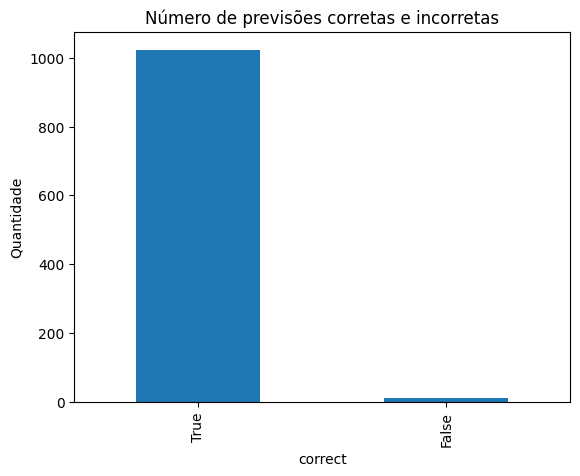

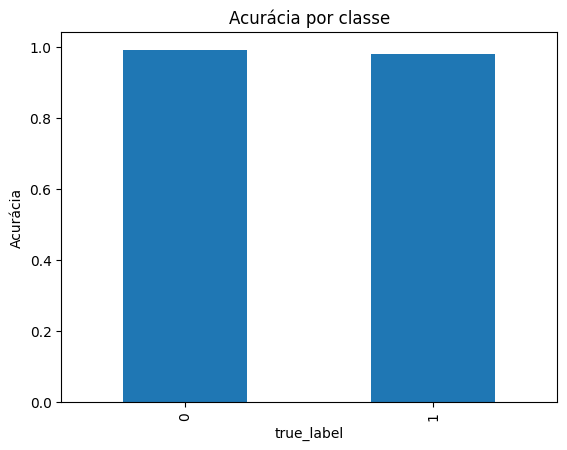

In [33]:
import matplotlib.pyplot as plt

# Contagem de acertos e erros
df_val["correct"].value_counts().plot(kind="bar")
plt.title("Número de previsões corretas e incorretas")
plt.ylabel("Quantidade")
plt.show()

# Acurácia por classe
class_acc = df_val.groupby("true_label")["correct"].mean()
class_acc.plot(kind="bar")
plt.title("Acurácia por classe")
plt.ylabel("Acurácia")
plt.show()


In [34]:
# Exibir alguns textos com suas previsões
for i, row in df_val.sample(5).iterrows():
    print(f"Texto: {row['text']}")
    print(f"Verdadeiro: {row['true_label']}, Previsto: {row['pred_label']}, Correto: {row['correct']}")
    print("-"*80)


Texto: new arrival ? ? hi out there , welllllllll ! ! ! what ' s the word ? assume baby is here and you are all kicked back with nothing going on ( chuckle ) . when you have time give me a call ( again chuckle ) ken - attl . htm
Verdadeiro: 0, Previsto: 0, Correto: True
--------------------------------------------------------------------------------
Texto: confirming requisitions confirming the open requistions for your group . if your records indicate otherwise , please let me know . lisa csikos 104355 , 104001 rita wynne 104354 daren farmer 104210 mike eiben 104323 pat clynes 104285 mary smith 104301 steve venturatos 59127 , 104353 the posting dates have all been updated to reflect a current posting date . thanks for your support ! ! toni
Verdadeiro: 1, Previsto: 1, Correto: True
--------------------------------------------------------------------------------
Texto: windows xp suites 242296 specials good thru 11 / 12 / 03 . please use discount code mail 9221 to receive these prices .